In [ ]:
import os

import anndata as ad
import pandas as pd
# import scanpy as sc
import simba as si

prefix = '/mnt/d/PsychAD'

/home/noahcohenkalafut/miniconda3/envs/env_simba/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


ModuleNotFoundError: No module named 'scanpy'

# Get Data

In [ ]:
# Load pseudocells
dataset_name = 'PsychAD'
data = pd.read_csv(os.path.join(prefix, f'pseudobulk_{dataset_name}.csv.gz'), index_col=0, compression='gzip').T
adata = ad.AnnData(data)

# # Load from source
# adata_psychad = sc.read_h5ad(os.path.join(prefix, 'psychAD_snRNAseq_rawCounts.h5ad'), backed='r')
# # adata_seaad = sc.read_h5ad(os.path.join(prefix, 'SEAAD_A9_RNAseq_final-nuclei.2024-02-13.h5ad'), backed='r')
# # adata_seaad = ad.AnnData(adata_seaad.X, obs=adata_seaad.obs, var=adata_seaad.var)
# # Remove HBCC from training
# mask_psychad = adata_psychad.obs['Source'] == 'HBCC'
# mask_psychad = ~mask_psychad

/home/noahcohenkalafut/miniconda3/envs/env_simba/lib/python3.9/site-packages/anndata/utils.py:304: UserWarning: X converted to numpy array with dtype object
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/home/noahcohenkalafut/miniconda3/envs/env_simba/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Run SIMBA

In [ ]:
# Filter
si.pp.filter_genes(adata, min_n_cells=3)
si.pp.cal_qc_rna(adata)
si.pp.filter_cells_rna(adata, min_n_genes=100)

Before filtering: 
29923 cells, 34890 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
29923 cells, 34890 genes
before filtering: 
29923 cells,  34890 genes
filter cells based on min_n_genes
after filtering out low-quality cells: 
29923 cells,  34890 genes


In [ ]:
# Normalize
si.pp.normalize(adata, method='lib_size')
si.pp.log_transform(adata)

2000 variable genes are selected.


/home/noahcohenkalafut/miniconda3/envs/env_simba/lib/python3.9/site-packages/simba/plotting/_plot.py:550: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts = [plt.text(means[i], variances_norm[i], genes[i],


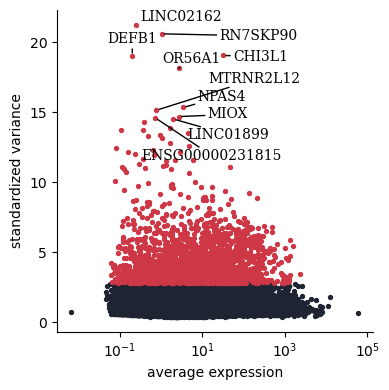

In [ ]:
# Variable gene selection
si.pp.select_variable_genes(adata, n_top_genes=2000)
si.pl.variable_genes(adata, show_texts=True)

In [ ]:
# Discretize
si.tl.discretize(adata, n_bins=5)

In [ ]:
# Generate training graph
si.tl.gen_graph(
    list_CG=[adata],
    layer='simba',
    use_highly_variable=False,
    dirname='graph0')

relation0: source: C, destination: G
#edges: 282035790
relation1: source: C, destination: G
#edges: 132027941
relation2: source: C, destination: G
#edges: 84154842
relation3: source: C, destination: G
#edges: 35169220
relation4: source: C, destination: G
#edges: 8088003
Total number of edges: 541475796
Writing graph file "pbg_graph.txt" to "./result_simba/pbg/graph0" ...
Finished.


In [ ]:
# Train model
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 4.4e-05
Weight decay being used for training is 4.4e-05
Converting input data ...
[2025-03-31 13:11:11.541313] Using the 5 relation types given in the config
[2025-03-31 13:11:11.542414] Searching for the entities in the edge files...
[2025-03-31 13:20:09.019704] Entity type C:
[2025-03-31 13:20:09.023821] - Found 29923 entities
[2025-03-31 13:20:09.024273] - Removing the ones with fewer than 1 occurrences...
[2025-03-31 13:20:09.035253] - Left with 29923 entities
[2025-03-31 13:20:09.035920] - Shuffling them...
[2025-03-31 13:20:09.057918] Entity type G:
[2025-03-31 13:20:09.058576] - Found 34890 entities
[2025-03-31 13:20:09.059025] - Removing the ones with fewer than 1 occurrences...
[2025-03-31 13:20:09.068306] - Left with 34890 entities
[2025-03-31 13:20:09.069278] - Shuffling them...
[2025-03-31 13:20:09.100912] Preparing counts and dictionaries for entities and relation types:
[2025-03-31 13:20:09.

In [ ]:
# Load graph and model
si.load_graph_stats()
si.load_pbg_config()

In [ ]:
# Load embeddings
dict_adata = si.read_embedding()
adata_C = dict_adata['C']  # Cell embeddings
adata_G = dict_adata['G']  # Gene embeddings

In [ ]:
dataset_name = 'PsychAD'

In [ ]:
# Save embeddings
adata_C.X.to_csv(os.path.join(prefix, f'SIMBA/{dataset_name}.csv'))